In [1]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
import torch
from torch.utils.data.dataset import Subset
from torch.utils.data import DataLoader

# Allow Subset class for unpickling
torch.serialization.add_safe_globals([Subset])

# Load the datasets
test_subset = torch.load("data/cifar10_selected_test.pt", weights_only=False)
val_subset  = torch.load("data/cifar10_extended_val.pt", weights_only=False)

testloader = DataLoader(test_subset, batch_size=1, shuffle=False)
valloader  = DataLoader(val_subset,  batch_size=32, shuffle=True)

### Load Models 

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm

def compute_grad_cosine_similarity(source_model, target_models, loader, device='cuda', num_samples=1000):
    """
    Compute average gradient cosine similarity between a source model and several target models.
    """

    source_model.eval().to(device)
    for tm in target_models:
        tm.eval().to(device)

    cos = nn.CosineSimilarity(dim=1)
    criterion = nn.CrossEntropyLoss()

    # storage for mean cosine per target model
    sim_sums = torch.zeros(len(target_models), device=device)
    count = 0

    for imgs, labels in tqdm(loader, total=min(len(loader), num_samples // loader.batch_size), desc="Grad-Cos Sim"):
        imgs, labels = imgs.to(device), labels.to(device)
        batch_size = imgs.size(0)
        if count >= num_samples:
            break

        imgs.requires_grad_(True)

        # --- Source model gradient ---
        outputs_src = source_model(imgs)
        loss_src = criterion(outputs_src, labels)
        grad_src = torch.autograd.grad(loss_src, imgs, retain_graph=True)[0]
        grad_src = grad_src.view(batch_size, -1)
        grad_src = grad_src / (grad_src.norm(dim=1, keepdim=True) + 1e-8)

        # --- Target models gradients ---
        for i, tm in enumerate(target_models):
            imgs.grad = None  # clear gradient for next model
            outputs_tgt = tm(imgs)
            loss_tgt = criterion(outputs_tgt, labels)
            grad_tgt = torch.autograd.grad(loss_tgt, imgs, retain_graph=True)[0]
            grad_tgt = grad_tgt.view(batch_size, -1)
            grad_tgt = grad_tgt / (grad_tgt.norm(dim=1, keepdim=True) + 1e-8)

            # cosine similarity per sample
            sim_batch = torch.sum(grad_src * grad_tgt, dim=1)
            sim_sums[i] += sim_batch.mean()

        count += batch_size
        if count >= num_samples:
            break

    # average similarities
    sim_means = (sim_sums / (count / loader.batch_size)).detach().cpu()
    result = {f"model_{i}": sim_means[i].item() for i in range(len(target_models))}
    return result

In [5]:
import model_helper as helper

device = 'cuda' if torch.cuda.is_available() else 'cpu' 

target_models_args = [
    "resnetv2_101x1_bitm", 
    "resnet152", 
    "regnety_160", 
    "vit_base_patch16_224", 
    "deit_base_patch16_224", 
    "swin_base_patch4_window7_224", 
    "convmixer_768_32"
    ]

target_models = [] 

for i in target_models_args: 
    model = helper.load_model_hub(i)
    model = model.to(device)
    target_models.append(model.eval())


🔹 Loading resnetv2_101x1_bitm from Models/target/resnetv2_101x1_bitm.pth.tar
Load result: <All keys matched successfully>

🔹 Loading vit_base_patch16_224 from Models/target/vit_base.pth.tar
Load result: <All keys matched successfully>

🔹 Loading deit_base_patch16_224 from Models/target/deit_base.pth.tar
Load result: <All keys matched successfully>

🔹 Loading swin_base_patch4_window7_224 from Models/target/swin_base.pth.tar
Load result: <All keys matched successfully>


In [17]:
import model_helper as helper


ens_models_args = [
    "resnet18", 
    "inception_v3", 
    "deit_tiny_patch16_224", 
    "vit_tiny_patch16_224", 
    "efficientnet_b0", 
    "gcvit_tiny"
    ]

model_name = ens_models_args[5]


model = helper.load_model_hub(model_name)
model = model.to(device)


In [18]:
compute_grad_cosine_similarity(model, target_models, testloader, device='cuda', num_samples=1000)  

Grad-Cos Sim: 100%|███████████████████████████████████████▉| 999/1000 [01:35<00:00, 10.48it/s]


{'model_0': 0.07909581810235977,
 'model_1': 0.08546417206525803,
 'model_2': 0.07640726119279861,
 'model_3': 0.05954485759139061,
 'model_4': 0.07194726169109344,
 'model_5': 0.0719018504023552,
 'model_6': 0.06132938340306282}

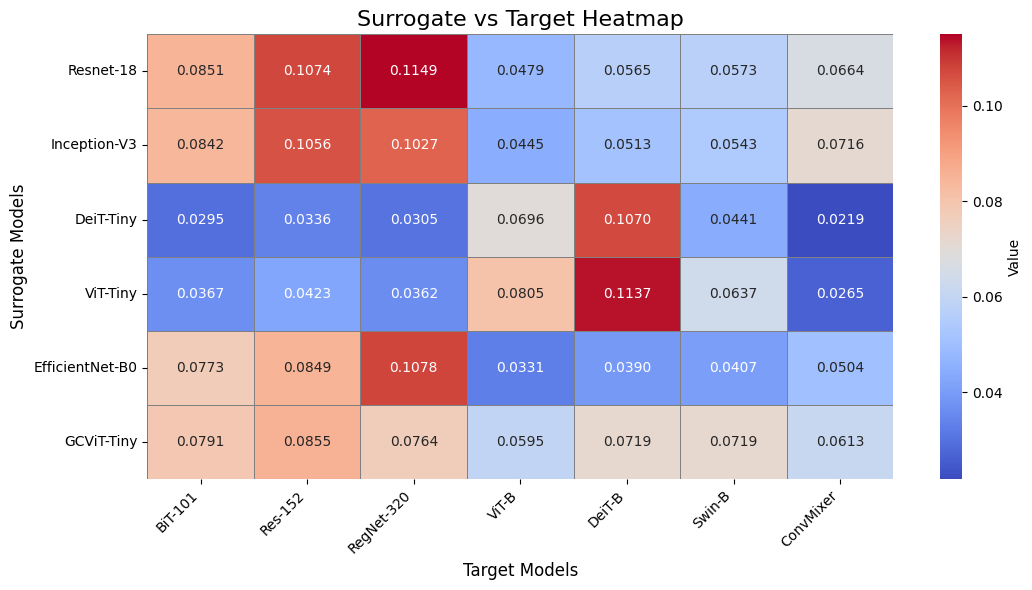

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# New Data Table
data5 = {
    "BiT-101":     [0.0851, 0.0842, 0.0295, 0.0367, 0.0773, 0.0791],
    "Res-152":     [0.1074, 0.1056, 0.0336, 0.0423, 0.0849, 0.0855],
    "RegNet-320":  [0.1149, 0.1027, 0.0305, 0.0362, 0.1078, 0.0764],
    "ViT-B":       [0.0479, 0.0445, 0.0696, 0.0805, 0.0331, 0.0595],
    "DeiT-B":      [0.0565, 0.0513, 0.1070, 0.1137, 0.0390, 0.0719],
    "Swin-B":      [0.0573, 0.0543, 0.0441, 0.0637, 0.0407, 0.0719],
    "ConvMixer":   [0.0664, 0.0716, 0.0219, 0.0265, 0.0504, 0.0613]
}

index5 = [
    "Resnet-18",
    "Inception-V3",
    "DeiT-Tiny",
    "ViT-Tiny",
    "EfficientNet-B0",
    "GCViT-Tiny"
]

df5 = pd.DataFrame(data5, index=index5)

# Plot heatmap
plt.figure(figsize=(11, 6))
sns.heatmap(df5, annot=True, fmt=".4f", cmap="coolwarm",
            cbar_kws={'label': 'Value'}, linewidths=0.5, linecolor='gray')

plt.title("Surrogate vs Target Heatmap", fontsize=16)
plt.xlabel("Target Models", fontsize=12)
plt.ylabel("Surrogate Models", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Save as SVG
plt.savefig("surrogate_target_heatmap.svg", format='svg')

plt.show()

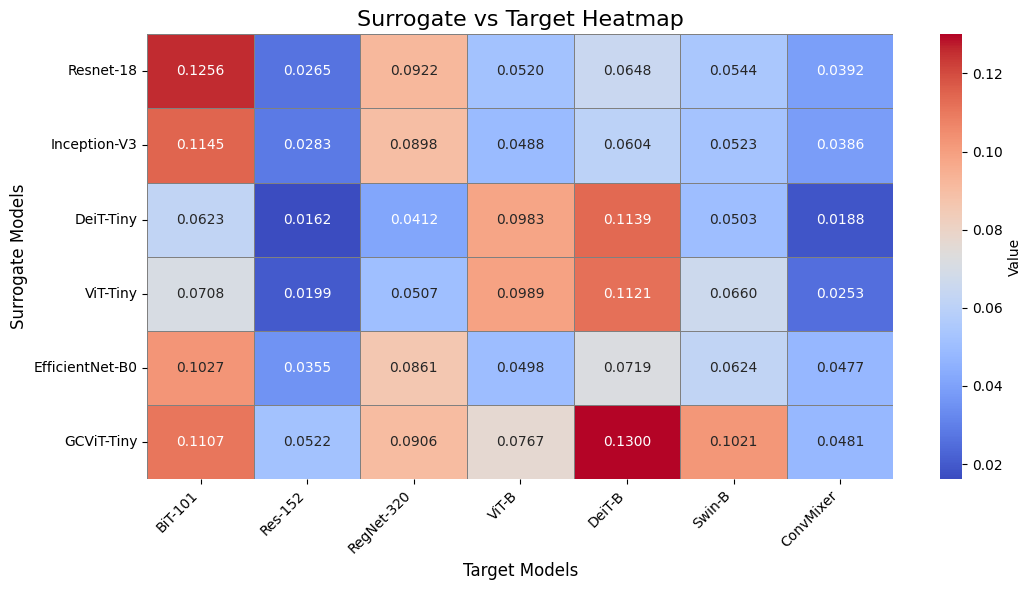

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Rounded Data Table
data4 = {
    "BiT-101":     [0.1256, 0.1145, 0.0623, 0.0708, 0.1027, 0.1107],
    "Res-152":     [0.0265, 0.0283, 0.0162, 0.0199, 0.0355, 0.0522],
    "RegNet-320":  [0.0922, 0.0898, 0.0412, 0.0507, 0.0861, 0.0906],
    "ViT-B":       [0.0520, 0.0488, 0.0983, 0.0989, 0.0498, 0.0767],
    "DeiT-B":      [0.0648, 0.0604, 0.1139, 0.1121, 0.0719, 0.1300],
    "Swin-B":      [0.0544, 0.0523, 0.0503, 0.0660, 0.0624, 0.1021],
    "ConvMixer":   [0.0392, 0.0386, 0.0188, 0.0253, 0.0477, 0.0481]
}

index4 = [
    "Resnet-18",
    "Inception-V3",
    "DeiT-Tiny",
    "ViT-Tiny",
    "EfficientNet-B0",
    "GCViT-Tiny"
]

df4 = pd.DataFrame(data4, index=index4)

# Plot heatmap
plt.figure(figsize=(11, 6))
sns.heatmap(df4, annot=True, fmt=".4f", cmap="coolwarm",
            cbar_kws={'label': 'Value'}, linewidths=0.5, linecolor='gray')

plt.title("Surrogate vs Target Heatmap", fontsize=16)
plt.xlabel("Target Models", fontsize=12)
plt.ylabel("Surrogate Models", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

plt.savefig("surrogate_target_heatmap.svg", format='svg')

plt.show()
